In [1]:
#setup
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
#label classes
classes = { 0:"Speed Limit (5km/h)",
          1:"Speed Limit (15km/h)",
          2:"Speed Limit (30km/h)",
          3:"Speed Limit (40km/h)",
          4:"Speed Limit (50km/h)",
          5:"Speed Limit (60km/h)",
          6:"Speed Limit (70km/h)",
          7:"Speed Limit (80km/h)",
          8:"No proceed straight and left turns",
          9:"No proceed straight and right turns",
          10:"No proceed straight",
          11:"No left turn",
          12:"No left and right turns",
          13:"No right turn",
          14:"No overtaking",
          15:"No U-turns",
          16:"No motor vehicles",
          17:"No honking",
          18:"End of maximum speed limit (40km/h)",
          19:"End of maximum speed limit (50km/h)",
          20:"Proceed straight and/or Turn right",
          21:"Proceed straight",
          22:"Turn left",
          23:"Turn left and/or right",
          24:"Turn right",
          25:"Keep left side",
          26:"Keep right side",
          27:"Roundabout",
          28:"High-occupancy vehicle lane",
          29:"Honking",
          30:"Bicycles only",
          31:"Lane for U-turn",
          32:"Turn left and/or right to detour",
          33:"Traffic Lights ahead",
          34:"Be careful",
          35:"Pedestrian crossing ahead",
          36:"Cyclists",
          37:"School ahead",
          38:"Curve to the right",
          39:"Curve to the left",
          40:"Steep descent",
          41:"Steep ascent",
          42:"Slow",
          43:"Side road junction ahead on the right",
          44:"Side road junction ahead on the left",
          45:"Cross-village road",
          46:"Double curve, with turn right first, then left",
          47:"Locomotive railroad crossing ahead (without safety barriers)",
          48:"Roadworks ahead",
          49:"Multiple curves",
          50:"Railroad head (with safety barriers)",
          51:"Accident area",
          52:"Stop",
          53:"No entry for vehicular and pedestrians",
          54:"No stopping",
          55:"No entry for vehicular traffic",
          56:"Give way",
          57:"Control"}

In [3]:
#read annotation file
txt = np.genfromtxt('dataset/gt_train.txt',delimiter =';', dtype= None,encoding=None)

#Creating a dictionary with image names as key and annotations as value
dic ={}
for i in range (0,len(txt)):
    #Image name is first element of annotation file
    img_name = txt[i][0]
    # 4 Coordinates
    target = [txt[i][1],txt[i][2],txt[i][3],txt[i][4],txt[i][5], txt[i][6], txt[i][7]]
    #Last element is the class number
    clas = txt[i][-1]
    #If multiple objects, store coordinates and classes as list of lists
    if(img_name in dic):
        dic[img_name].append(target)
        
    else:
        dic[img_name] = [target]
print(dic['000_0001.png'])
print("Number of Images: " + str(len(dic)))

[[134, 128, 19, 7, 120, 117, 0]]
Number of Images: 4170


{0: 118, 1: 40, 2: 80, 3: 260, 4: 98, 5: 194, 6: 78, 7: 152, 8: 8, 9: 2, 10: 70, 11: 138, 12: 96, 13: 36, 14: 128, 15: 22, 16: 142, 17: 130, 18: 8, 19: 4, 20: 18, 21: 12, 22: 18, 23: 14, 24: 100, 25: 2, 26: 126, 27: 28, 28: 446, 29: 44, 30: 150, 31: 42, 32: 14, 33: 4, 34: 26, 35: 156, 36: 40, 37: 58, 38: 30, 39: 34, 40: 32, 41: 18, 42: 32, 43: 82, 44: 30, 45: 24, 46: 18, 47: 12, 48: 10, 49: 42, 50: 56, 51: 8, 52: 36, 53: 2, 54: 324, 55: 162, 56: 110, 57: 6}


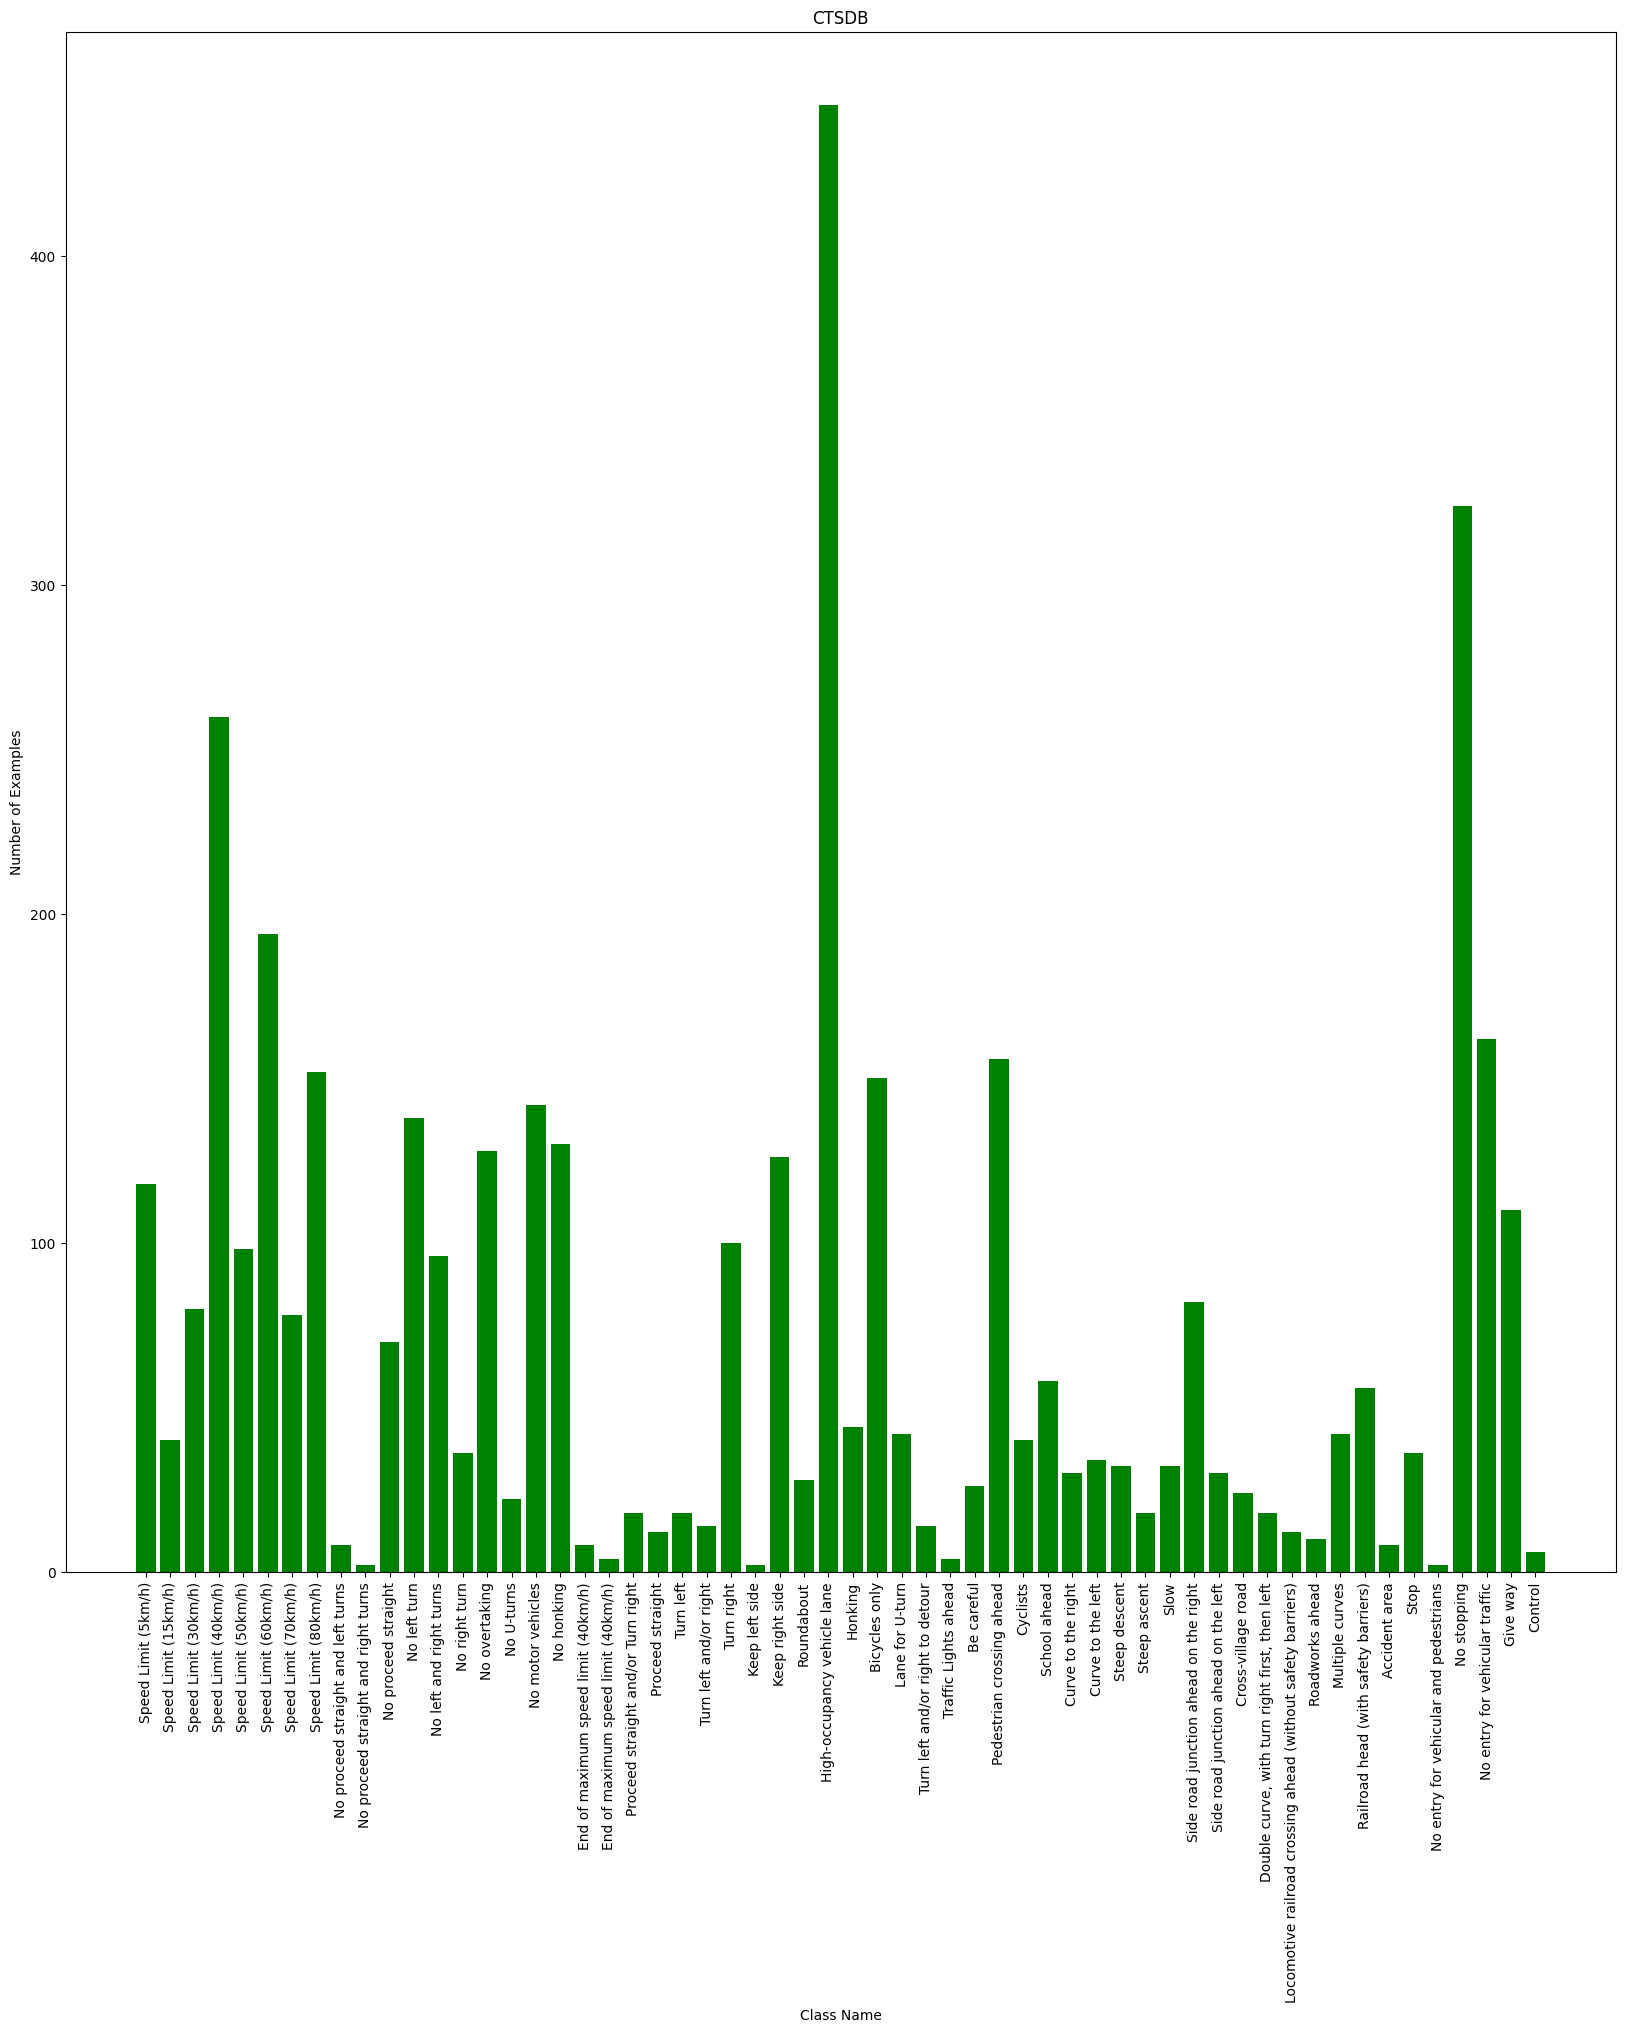

In [4]:
#Data Distribution

cls_lst = {}

for i in dic:
    for j in dic[i][:]:
        #print(len(dic[i]))
        for k in range(len(dic[i])):
            clss = dic[i][:][k][-1]
            if clss in cls_lst:
                cls_lst[clss] += 1
            else:
                cls_lst[clss] = 1
                
print(cls_lst)

xx = []
yy = []
for i in cls_lst:
    xx.append(classes[i])
    yy.append(cls_lst[i])

x_pos = [i for i, _ in enumerate(xx)]
plt.figure(figsize=(20, 20))
plt.bar(x_pos, yy, color='green')
plt.xlabel("Class Name")
plt.ylabel("Number of Examples")
plt.title("CTSDB")
plt.xticks(x_pos, xx, rotation='vertical')



plt.show()

In [5]:
label_names = []

# Loop through the dictionary and append label names to the list
for class_number in range(len(classes)):
    label_names.append(classes[class_number])

# Now, label_names contains all the label names in the same order as the class numbers
label_names

['Speed Limit (5km/h)',
 'Speed Limit (15km/h)',
 'Speed Limit (30km/h)',
 'Speed Limit (40km/h)',
 'Speed Limit (50km/h)',
 'Speed Limit (60km/h)',
 'Speed Limit (70km/h)',
 'Speed Limit (80km/h)',
 'No proceed straight and left turns',
 'No proceed straight and right turns',
 'No proceed straight',
 'No left turn',
 'No left and right turns',
 'No right turn',
 'No overtaking',
 'No U-turns',
 'No motor vehicles',
 'No honking',
 'End of maximum speed limit (40km/h)',
 'End of maximum speed limit (40km/h)',
 'Proceed straight and/or Turn right',
 'Proceed straight',
 'Turn left',
 'Turn left and/or right',
 'Turn right',
 'Keep left side',
 'Keep right side',
 'Roundabout',
 'High-occupancy vehicle lane',
 'Honking',
 'Bicycles only',
 'Lane for U-turn',
 'Turn left and/or right to detour',
 'Traffic Lights ahead',
 'Be careful',
 'Pedestrian crossing ahead',
 'Cyclists',
 'School ahead',
 'Curve to the right',
 'Curve to the left',
 'Steep descent',
 'Steep ascent',
 'Slow',
 'Side 

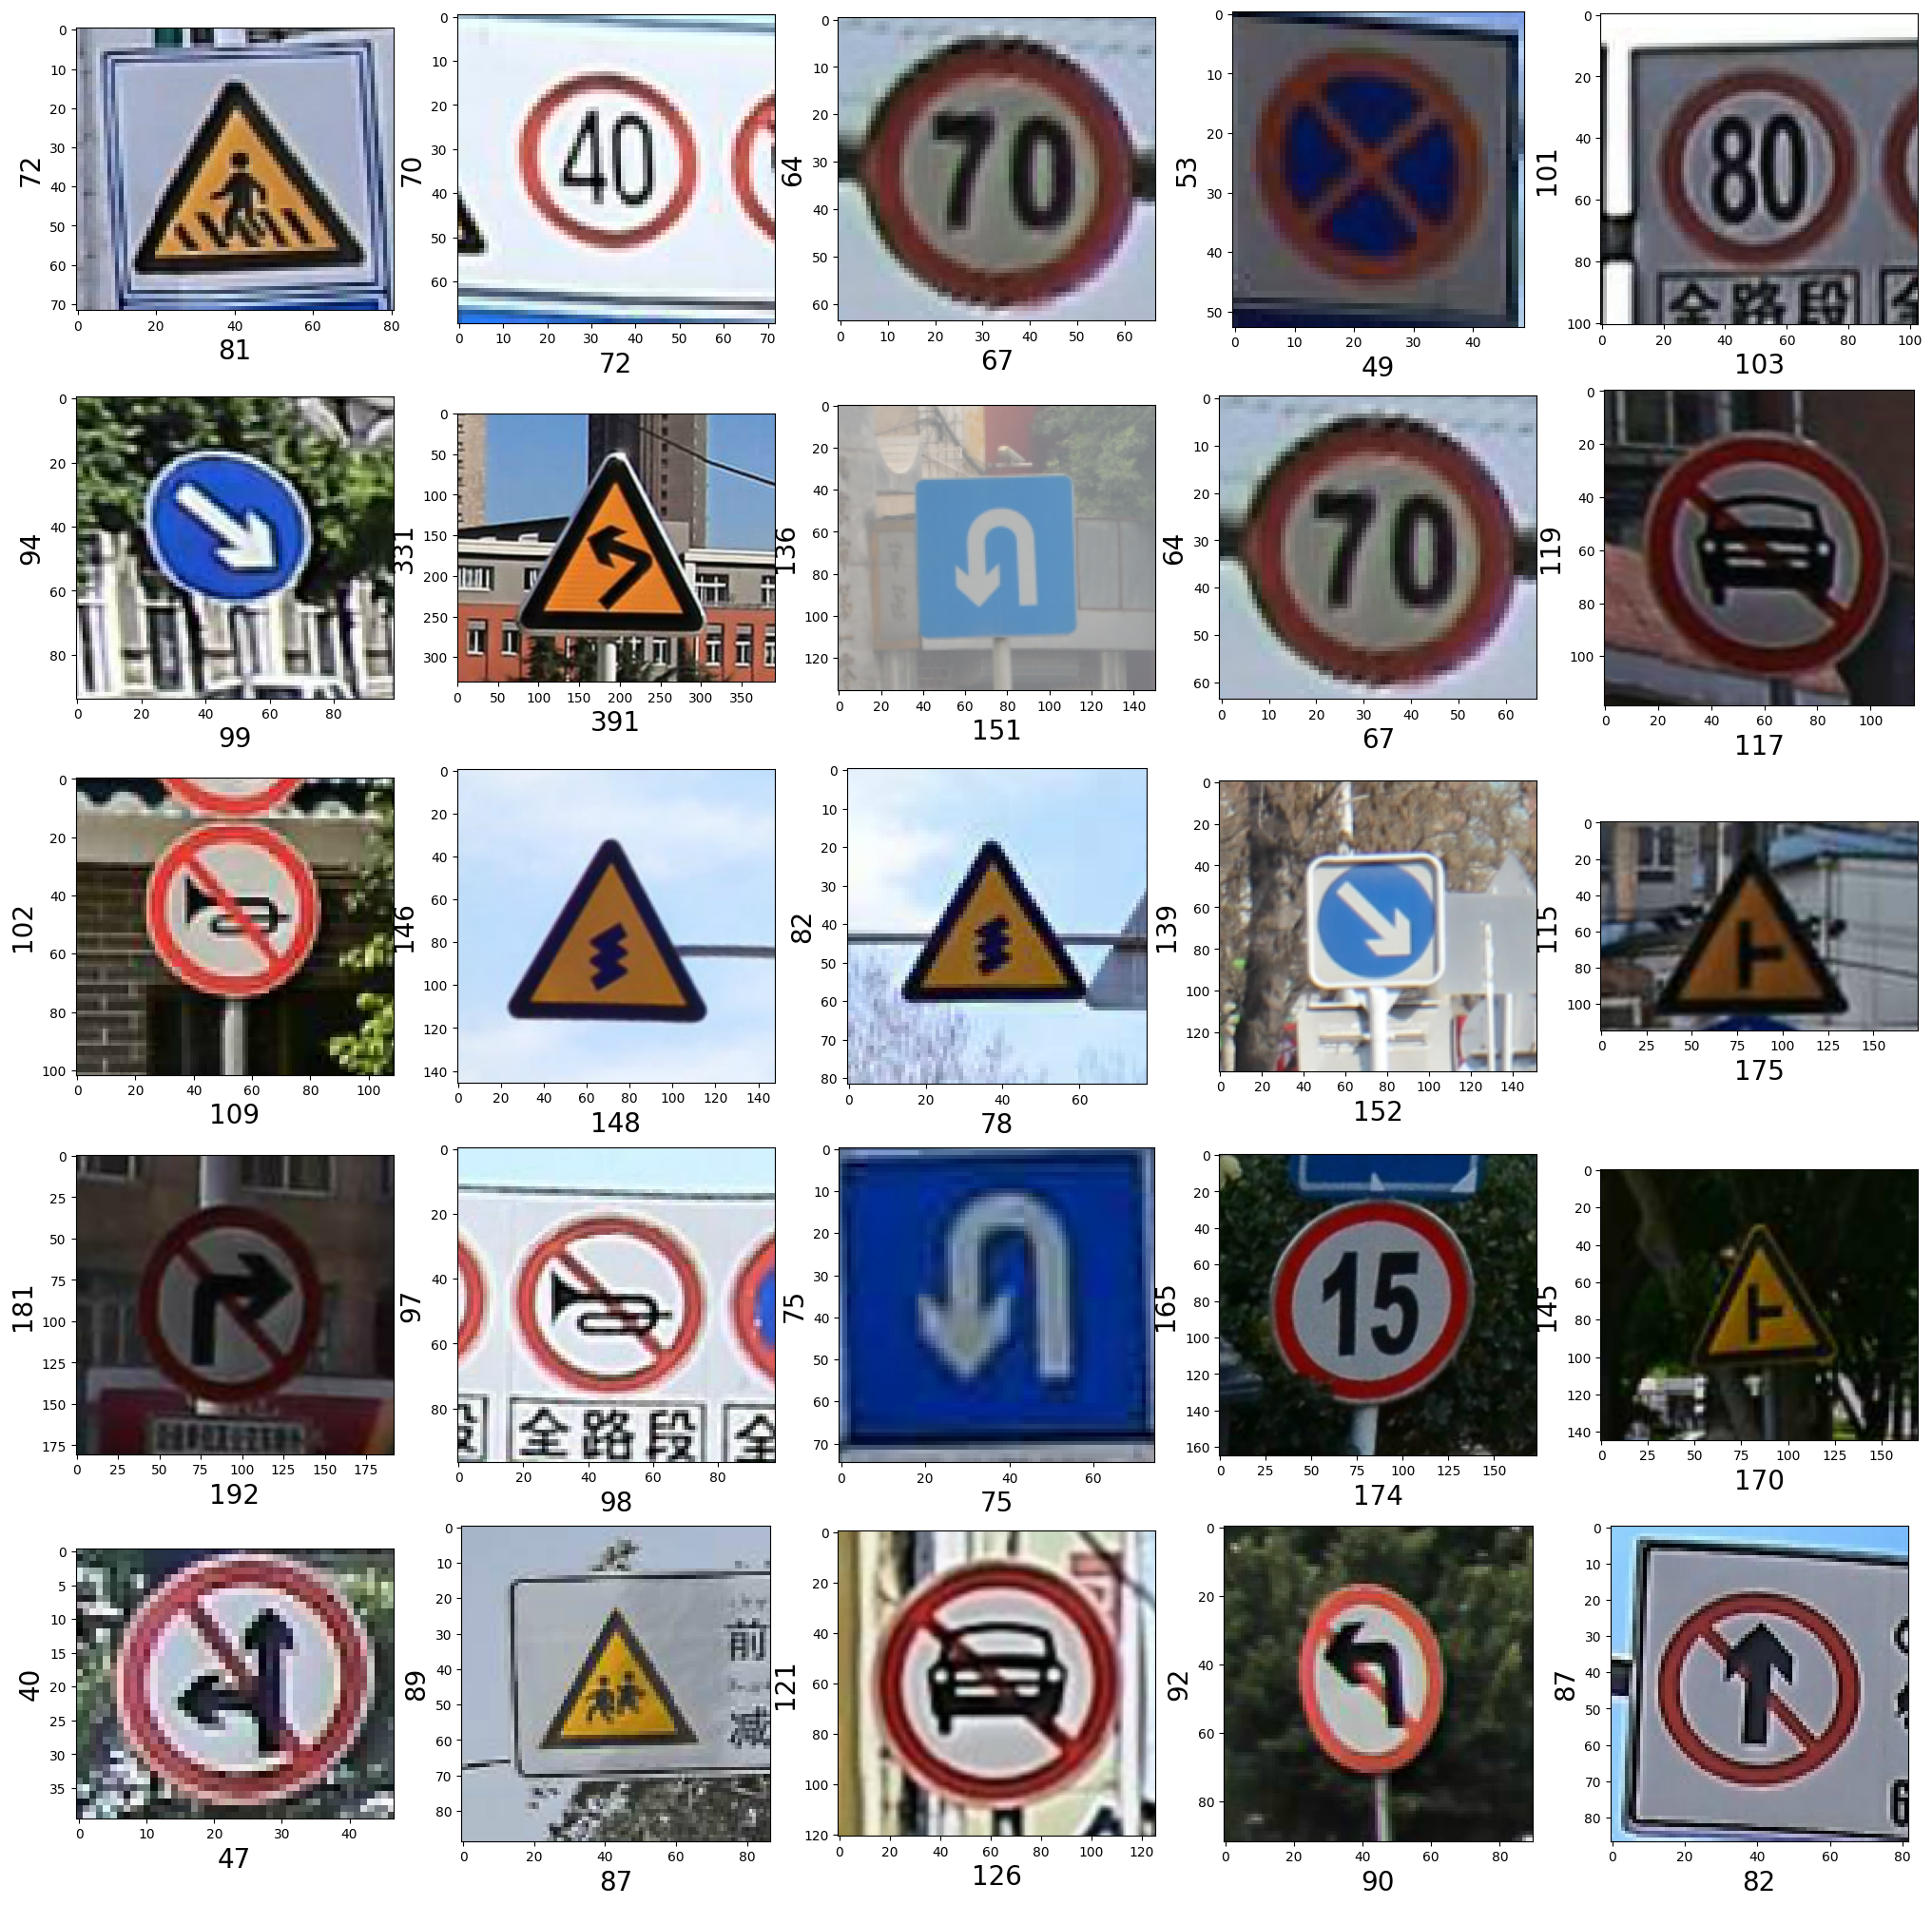

In [6]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

txt_test = np.genfromtxt('dataset/gt_test.txt',delimiter =';', dtype= None,encoding=None)

#Creating a dictionary with image names as key and annotations as value
dic_test ={}
for i in range (0,len(txt_test)):
    #Image name is first element of annotation file
    img_name = txt_test[i][0]
    # 4 Coordinates
    target = [txt_test[i][1],txt_test[i][2],txt_test[i][3],txt_test[i][4],txt_test[i][5], txt_test[i][6], txt_test[i][7]]
    #Last element is the class number
    clas = txt_test[i][-1]
    #If multiple objects, store coordinates and classes as list of lists
    if(img_name in dic_test):
        dic_test[img_name].append(target)
        
    else:
        dic_test[img_name] = [target]
        
pic_name = list(dic_test.keys()) # List of keys
random.shuffle(pic_name)

'''
for i in range(0, 24):
    print(pic_name[i])
print(dic_test['043_1_0014_1_j.png'])
print("Number of Images: " + str(len(dic_test)))
'''

plt.figure(figsize=(25,25))
test_path = 'dataset/Test/'
for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = test_path + pic_name[i]
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image



## Collecting the Training Data

In [7]:
image_data = []
image_labels = []
IMG_HEIGHT = 24
IMG_WIDTH = 24
channels = 3
data_dir = 'dataset'
train_path = 'dataset/Train/'
test_path = 'dataset/Test/'
# path = data_dir + '/Train/'
images = os.listdir("dataset/Train/")

for img in images:
    try:
        # image = cv2.imread(train_path + img)
        image = cv2.imread("dataset/Train/"+ img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        image_data.append(np.array(resize_image))
        image_labels.append(dic[img][0][-1])

    except:
        print("Error in " + img)
        
# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(4170, 24, 24, 3) (4170,)


## Shuffling the training data

In [8]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [9]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (2919, 24, 24, 3)
X_valid.shape (1251, 24, 24, 3)
y_train.shape (2919,)
y_valid.shape (1251,)


## One hot encoding the labels

In [10]:
NUM_CATEGORIES= len(label_names)
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(2919, 58)
(1251, 58)


## Building the model

In [11]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(58, activation='softmax')
])

In [12]:
#define hyperparameter
lr = 0.001
epochs = 1000

#defining an optimizer and compiling a neural network mode
opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
#data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

#training
history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/1000
92/92 [==============================] - 5s 40ms/step - loss: 2.4292 - accuracy: 0.4224 - val_loss: 4.3069 - val_accuracy: 0.0616
Epoch 2/1000
92/92 [==============================] - 4s 39ms/step - loss: 1.2123 - accuracy: 0.6560 - val_loss: 6.3707 - val_accuracy: 0.0192
Epoch 3/1000
92/92 [==============================] - 4s 39ms/step - loss: 0.8610 - accuracy: 0.7482 - val_loss: 7.0052 - val_accuracy: 0.0320
Epoch 4/1000
92/92 [==============================] - 3s 32ms/step - loss: 0.6158 - accuracy: 0.8184 - val_loss: 6.2671 - val_accuracy: 0.0504
Epoch 5/1000
92/92 [==============================] - 3s 29ms/step - loss: 0.4938 - accuracy: 0.8578 - val_loss: 1.7966 - val_accuracy: 0.4388
Epoch 6/1000
92/92 [==============================] - 3s 29ms/step - loss: 0.4097 - accuracy: 0.8794 - val_loss: 0.8326 - val_accuracy: 0.7282
Epoch 7/1000
92/92 [==============================] - 3s 29ms/step - loss: 0.3120 - accuracy: 0.9099 - val_loss: 0.4896 - val_accuracy: 0.8481

Epoch 58/1000
92/92 [==============================] - 3s 34ms/step - loss: 0.0388 - accuracy: 0.9880 - val_loss: 0.0180 - val_accuracy: 0.9960
Epoch 59/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0316 - accuracy: 0.9911 - val_loss: 0.0417 - val_accuracy: 0.9872
Epoch 60/1000
92/92 [==============================] - 3s 32ms/step - loss: 0.0383 - accuracy: 0.9853 - val_loss: 0.0109 - val_accuracy: 0.9960
Epoch 61/1000
92/92 [==============================] - 3s 34ms/step - loss: 0.0398 - accuracy: 0.9887 - val_loss: 0.1327 - val_accuracy: 0.9608
Epoch 62/1000
92/92 [==============================] - 3s 33ms/step - loss: 0.0446 - accuracy: 0.9846 - val_loss: 0.0148 - val_accuracy: 0.9976
Epoch 63/1000
92/92 [==============================] - 3s 37ms/step - loss: 0.0421 - accuracy: 0.9870 - val_loss: 0.0152 - val_accuracy: 0.9952
Epoch 64/1000
92/92 [==============================] - 3s 36ms/step - loss: 0.0285 - accuracy: 0.9908 - val_loss: 0.0212 - val_accuracy:

Epoch 115/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0262 - accuracy: 0.9901 - val_loss: 0.0129 - val_accuracy: 0.9968
Epoch 116/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0231 - accuracy: 0.9914 - val_loss: 0.0187 - val_accuracy: 0.9968
Epoch 117/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0544 - accuracy: 0.9856 - val_loss: 0.0107 - val_accuracy: 0.9976
Epoch 118/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 0.0183 - val_accuracy: 0.9968
Epoch 119/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0254 - accuracy: 0.9911 - val_loss: 0.0262 - val_accuracy: 0.9960
Epoch 120/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0140 - accuracy: 0.9952 - val_loss: 0.0151 - val_accuracy: 0.9960
Epoch 121/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0175 - accuracy: 0.9949 - val_loss: 0.0136 - val_ac

92/92 [==============================] - 3s 30ms/step - loss: 0.0067 - accuracy: 0.9959 - val_loss: 0.0212 - val_accuracy: 0.9984
Epoch 228/1000
92/92 [==============================] - 3s 29ms/step - loss: 0.0130 - accuracy: 0.9952 - val_loss: 0.0169 - val_accuracy: 0.9936
Epoch 229/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0135 - accuracy: 0.9966 - val_loss: 0.0058 - val_accuracy: 0.9984
Epoch 230/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 231/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0044 - accuracy: 0.9979 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 232/1000
92/92 [==============================] - 3s 29ms/step - loss: 0.0066 - accuracy: 0.9973 - val_loss: 0.0068 - val_accuracy: 0.9984
Epoch 233/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0025 - accuracy: 0.9990 - val_loss: 0.0076 - val_accuracy: 0.9968


92/92 [==============================] - 3s 35ms/step - loss: 0.0074 - accuracy: 0.9979 - val_loss: 0.0237 - val_accuracy: 0.9984
Epoch 340/1000
92/92 [==============================] - 3s 34ms/step - loss: 0.0088 - accuracy: 0.9973 - val_loss: 0.0179 - val_accuracy: 0.9968
Epoch 341/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0159 - accuracy: 0.9959 - val_loss: 0.0089 - val_accuracy: 0.9984
Epoch 342/1000
92/92 [==============================] - 3s 33ms/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0237 - val_accuracy: 0.9984
Epoch 343/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0123 - accuracy: 0.9959 - val_loss: 0.0533 - val_accuracy: 0.9952
Epoch 344/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0193 - accuracy: 0.9962 - val_loss: 0.0721 - val_accuracy: 0.9912
Epoch 345/1000
92/92 [==============================] - 3s 32ms/step - loss: 0.0066 - accuracy: 0.9990 - val_loss: 0.0105 - val_accuracy: 0.9968


92/92 [==============================] - 3s 33ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0212 - val_accuracy: 0.9968
Epoch 452/1000
92/92 [==============================] - 3s 34ms/step - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0213 - val_accuracy: 0.9968
Epoch 453/1000
92/92 [==============================] - 3s 32ms/step - loss: 0.0094 - accuracy: 0.9979 - val_loss: 0.0236 - val_accuracy: 0.9968
Epoch 454/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0064 - accuracy: 0.9986 - val_loss: 0.0175 - val_accuracy: 0.9984
Epoch 455/1000
92/92 [==============================] - 3s 32ms/step - loss: 0.0044 - accuracy: 0.9983 - val_loss: 0.0064 - val_accuracy: 0.9984
Epoch 456/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0069 - accuracy: 0.9973 - val_loss: 0.0409 - val_accuracy: 0.9968
Epoch 457/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0096 - accuracy: 0.9983 - val_loss: 0.0149 - val_accuracy: 0.9984


92/92 [==============================] - 3s 30ms/step - loss: 0.0052 - accuracy: 0.9979 - val_loss: 0.0205 - val_accuracy: 0.9984
Epoch 564/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0070 - accuracy: 0.9986 - val_loss: 0.0216 - val_accuracy: 0.9984
Epoch 565/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.0179 - val_accuracy: 0.9968
Epoch 566/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0071 - accuracy: 0.9983 - val_loss: 0.0194 - val_accuracy: 0.9968
Epoch 567/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0130 - val_accuracy: 0.9984
Epoch 568/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.0056 - val_accuracy: 0.9984
Epoch 569/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0106 - accuracy: 0.9983 - val_loss: 0.0230 - val_accuracy: 0.9984


92/92 [==============================] - 3s 30ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0318 - val_accuracy: 0.9968
Epoch 676/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0199 - val_accuracy: 0.9984
Epoch 677/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0239 - val_accuracy: 0.9984
Epoch 678/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0270 - val_accuracy: 0.9984
Epoch 679/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.0245 - val_accuracy: 0.9984
Epoch 680/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0256 - val_accuracy: 0.9984
Epoch 681/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0021 - accuracy: 0.9990 - val_loss: 0.0342 - val_accuracy: 0.9984


92/92 [==============================] - 3s 30ms/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.0235 - val_accuracy: 0.9984
Epoch 788/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0253 - val_accuracy: 0.9984
Epoch 789/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0087 - accuracy: 0.9983 - val_loss: 0.0294 - val_accuracy: 0.9984
Epoch 790/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0453 - val_accuracy: 0.9984
Epoch 791/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0514 - val_accuracy: 0.9984
Epoch 792/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.0442 - val_accuracy: 0.9984
Epoch 793/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.0370 - val_accuracy: 0.9968


92/92 [==============================] - 3s 30ms/step - loss: 0.0121 - accuracy: 0.9979 - val_loss: 0.0395 - val_accuracy: 0.9984
Epoch 900/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0026 - accuracy: 0.9983 - val_loss: 0.0344 - val_accuracy: 0.9984
Epoch 901/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.0381 - val_accuracy: 0.9984
Epoch 902/1000
92/92 [==============================] - 3s 31ms/step - loss: 0.0026 - accuracy: 0.9986 - val_loss: 0.0338 - val_accuracy: 0.9984
Epoch 903/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0395 - val_accuracy: 0.9968
Epoch 904/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0081 - accuracy: 0.9986 - val_loss: 0.0270 - val_accuracy: 0.9984
Epoch 905/1000
92/92 [==============================] - 3s 30ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0372 - val_accuracy: 0.9968


## Evaluating the model

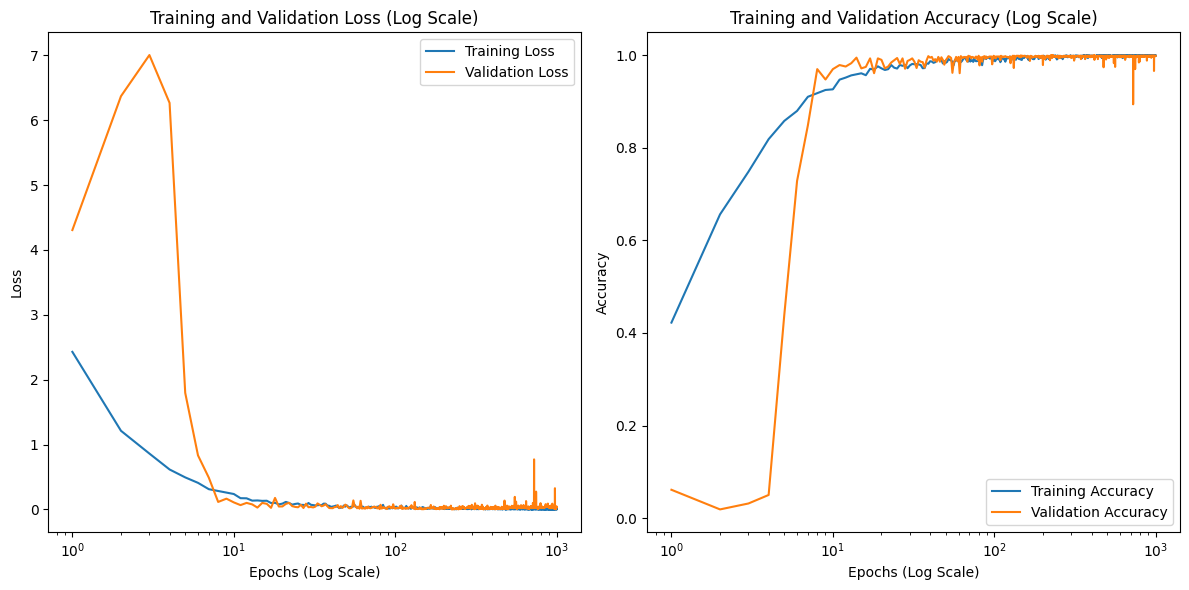

In [14]:
plt.figure(figsize=(12, 6))

# Plot training and validation loss with a logarithmic x-axis scale
plt.subplot(1, 2, 1)
plt.semilogx(range(1, len(history.history['loss']) + 1), history.history['loss'], label='Training Loss')
plt.semilogx(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Log Scale)')
plt.xlabel('Epochs (Log Scale)')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy with a logarithmic x-axis scale
plt.subplot(1, 2, 2)
plt.semilogx(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label='Training Accuracy')
plt.semilogx(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Log Scale)')
plt.xlabel('Epochs (Log Scale)')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Loading the test data and running the predictions

In [15]:
txt_pred = np.genfromtxt('dataset/gt_test.txt',delimiter =';', dtype= None,encoding=None)

#Creating a dictionary with image names as key and annotations as value
dic_pred ={}
for i in range (0,len(txt_pred)):
    #Image name is first element of annotation file
    img_name = txt_pred[i][0]
    # 4 Coordinates
    target = [txt_pred[i][1],txt_pred[i][2],txt_pred[i][3],txt_pred[i][4],txt_pred[i][5], txt_pred[i][6], txt_pred[i][7]]
    #Last element is the class number
    clas = txt_pred[i][-1]
    #If multiple objects, store coordinates and classes as list of lists
    if(img_name in dic_pred):
        dic_pred[img_name].append(target)
        
    else:
        dic_pred[img_name] = [target]
        
print(dic_pred['000_0001_j.png'])
print("Number of Images: " + str(len(dic_pred)))

[[50, 47, 14, 9, 35, 35, 0]]
Number of Images: 1994


In [16]:
from PIL import Image
from sklearn.metrics import accuracy_score
labels = []
imgs = []
data = []

# Load the test data
images = os.listdir("dataset/Test/")

for img in images:
    try: 
        image = cv2.imread("dataset/Test/" + img)
        label = dic_pred[img][0][6]
        labels.append(label)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        resize_image = image_fromarray.resize((IMG_WIDTH, IMG_HEIGHT))
        data.append(np.array(resize_image))

    except:
        print("Error in " + img)

X_test = np.array(data)
X_test = X_test / 255.0  # Normalize the test data

# convert labels array to numpyarray
labels = np.array(labels)

# Make predictions using the model
pred = model.predict(X_test)

# Convert predicted probabilities to class labels
pred_classes = np.argmax(pred, axis=1)

print('Shape of labels:', labels.shape)
print('Shape of pred_classes:', pred_classes.shape)

# Calculate accuracy with the test data
accuracy = accuracy_score(labels, pred_classes)
print('Test Data accuracy:', accuracy * 100)

63/63 [==============================] - 1s 7ms/step
Shape of labels: (1994,)
Shape of pred_classes: (1994,)
Test Data accuracy: 91.37412236710131


In [25]:
unique_labels = np.unique(labels)
unique_pred_classes = np.unique(pred_classes)

pred_classes

array([ 1,  0,  0, ..., 57, 57, 57], dtype=int64)

In [35]:
# find and print out missing classes in test data
numClasses=58
class_number = range(58)
class_number = np.array(class_number)
missing = np.setdiff1d(class_number, unique_labels)
print("Missing classes in test data:")
print(missing)

Missing classes in test data:
[ 9 18 19 33]


## Visualizing the confusion matrix

In [27]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
# compute confusion matrix that include all classes
all_classes = range(numClasses)
cf = confusion_matrix(labels, pred_classes, labels=all_classes)

<Axes: >

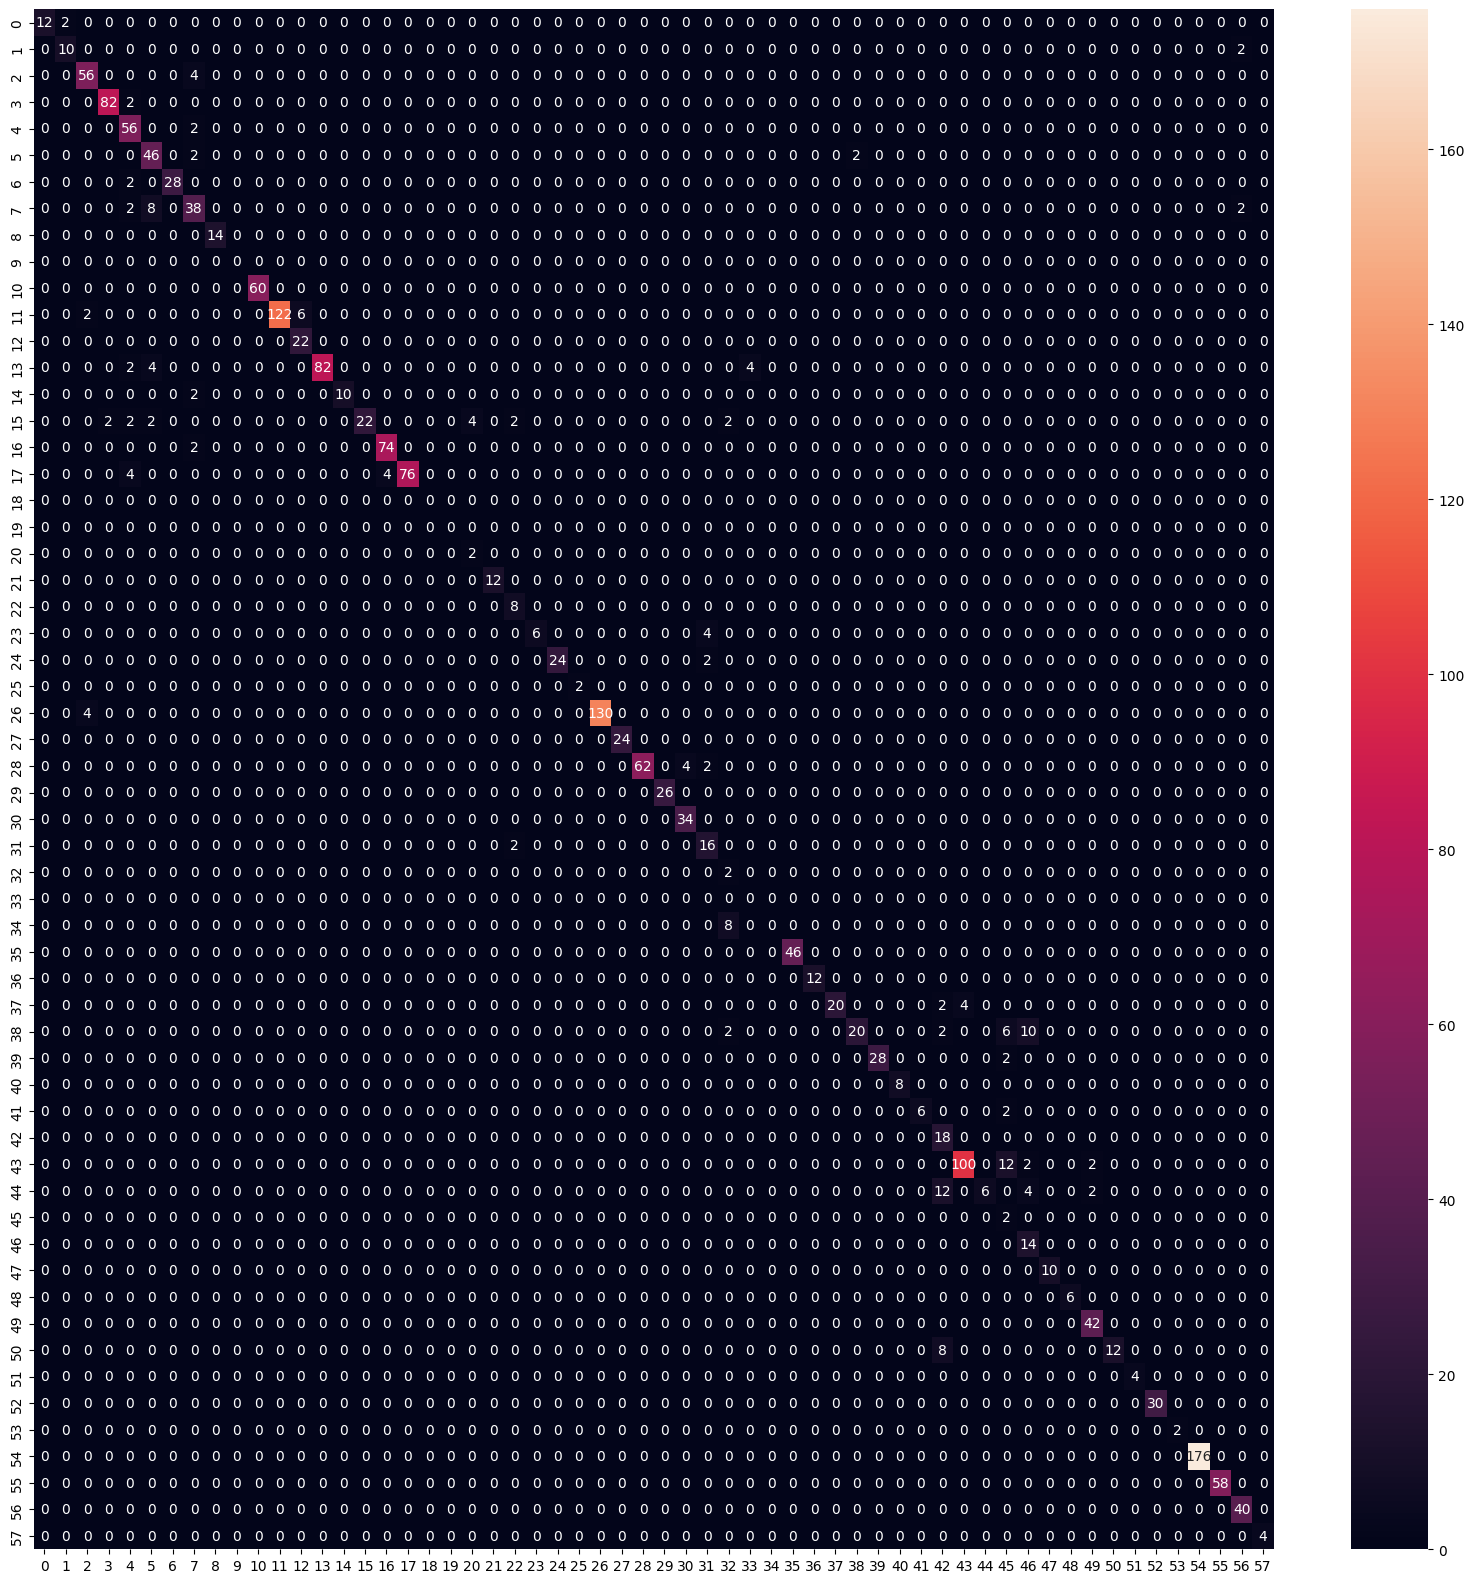

In [36]:
import seaborn as sns
plt.figure(figsize = (20,20))
sns.heatmap(cf, annot=True, fmt='d')

## Classification Report

In [47]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.83      0.83      0.83        12
           2       0.90      0.93      0.92        60
           3       0.98      0.98      0.98        84
           4       0.80      0.97      0.88        58
           5       0.77      0.92      0.84        50
           6       1.00      0.93      0.97        30
           7       0.76      0.76      0.76        50
           8       1.00      1.00      1.00        14
          10       1.00      1.00      1.00        60
          11       1.00      0.94      0.97       130
          12       0.79      1.00      0.88        22
          13       1.00      0.89      0.94        92
          14       1.00      0.83      0.91        12
          15       1.00      0.61      0.76        36
          16       0.95      0.97      0.96        76
          17       1.00      0.90      0.95        84
          20       0.33    

C:\Users\Kai Jing\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kai Jing\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kai Jing\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

## Predictions on Test Data

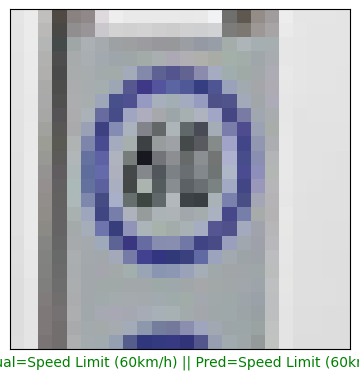

In [38]:
plt.figure(figsize = (15, 15))

start_index = 250
for i in range(1):
    plt.subplot(3, 3, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_classes[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(label_names[actual], label_names[prediction]), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

1/1 [==============================] - 0s 23ms/step
Actual=Keep right side || Pred=Keep right side


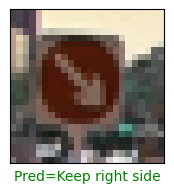

In [39]:
import random
import matplotlib.pyplot as plt

# Randomly select an index from your test dataset
random_index = random.randint(0, len(X_test) - 1)
# Get the image and label at the random index
random_image = X_test[random_index]
random_label = labels[random_index]

# Make a prediction for the random image
random_image = random_image.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3)  # Reshape for prediction
random_pred = model.predict(random_image)
random_pred_class = np.argmax(random_pred)

print('Actual={} || Pred={}'.format(label_names[random_label], label_names[random_pred_class]))
      
# Plot the random image and its prediction
plt.figure(figsize=(2, 2))
plt.imshow(random_image[0])
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Pred={}'.format(label_names[random_pred_class]), color = col)
plt.show()

### Show misclassified predictions

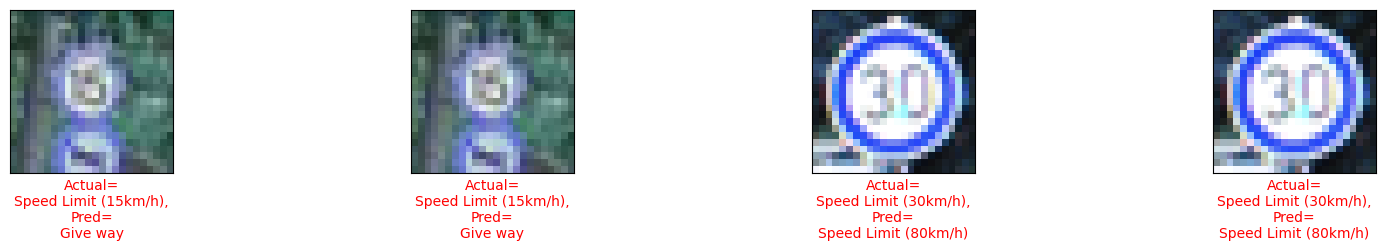

In [46]:
plt.figure(figsize=(25, 25))

start_index = 10
num_rows = 10
num_cols = 5

# Create a list to store the indices of incorrect predictions
incorrect_indices = []

for i in range(num_rows * num_cols):
    prediction = pred_classes[start_index + i]
    actual = labels[start_index + i]
# if prediction of img is not correct,append indices to the list
    if prediction != actual:
        incorrect_indices.append(start_index + i)

# create subplots only for incorrect predictions
for i, index in enumerate(incorrect_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_classes[index]
    actual = labels[index]

    col = 'r' 
    plt.xlabel('Actual=\n{},\nPred=\n{}'.format(label_names[actual],label_names[prediction]), color=col)
    plt.imshow(X_test[index])

plt.show()

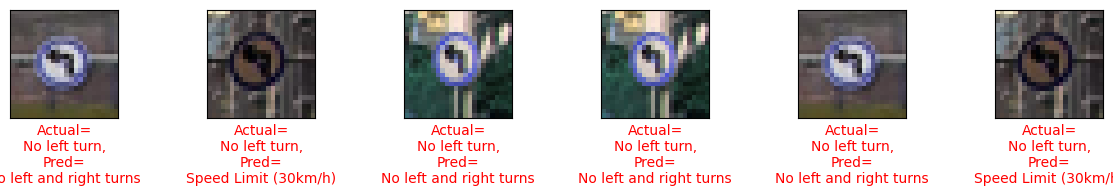

In [45]:
plt.figure(figsize=(25, 25))

start_index = 400
num_rows = 15
num_cols = 10

# Create a list to store the indices of incorrect predictions
incorrect_indices = []

for i in range(num_rows * num_cols):
    prediction = pred_classes[start_index + i]
    actual = labels[start_index + i]
# if prediction of img is not correct,append indices to the list
    if prediction != actual:
        incorrect_indices.append(start_index + i)

# create subplots only for incorrect predictions
for i, index in enumerate(incorrect_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_classes[index]
    actual = labels[index]

    col = 'r' 
    plt.xlabel('Actual=\n{},\nPred=\n{}'.format(label_names[actual],label_names[prediction]), color=col)
    plt.imshow(X_test[index])

plt.show()

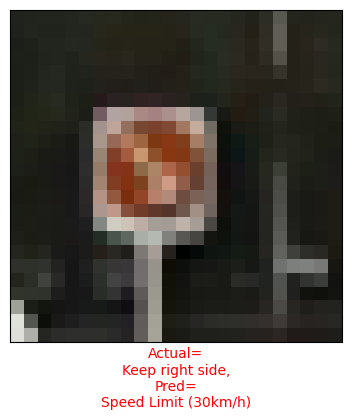

In [44]:
plt.figure(figsize=(25, 25))
start_index = 1000
num_rows = 5
num_cols = 5

# Create a list to store the indices of incorrect predictions
incorrect_indices = []

for i in range(num_rows * num_cols):
    prediction = pred_classes[start_index + i]
    actual = labels[start_index + i]
# if prediction of img is not correct,append indices to the list
    if prediction != actual:
        incorrect_indices.append(start_index + i)

# create subplots only for incorrect predictions
for i, index in enumerate(incorrect_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred_classes[index]
    actual = labels[index]

    col = 'r'
    plt.xlabel('Actual=\n{},\nPred=\n{}'.format(label_names[actual],label_names[prediction]), color=col)
    plt.imshow(X_test[index])
plt.show()


## Saving model



In [43]:
# Save the entire model to a file in the HDF5 format
model.save('model.keras')

